In [9]:
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt

# --- STEP 1: Load All Data ---

# Load zoning shapefile
zones = gpd.read_file(r"C:\Users\hp\Documents\MUDITA-doc\Projects\Illegal construction detection\HomogenousSubZones")

# Load zoning rules CSV
rules = pd.read_csv("Chandigarh Housing Rules 1 - Sheet2.csv")

# Load DSM (CartoDEM)
dsm = rasterio.open(r"C:\Users\hp\Documents\MUDITA-doc\Projects\Illegal construction detection\P5_PAN_CD_N30_000_E076_000_DEM_30m.tif")


# Load DTM (SRTM)
dtm = rasterio.open("n30_e076_1arc_v3.tif")

# --- STEP 2: Clean + Join Rules with Zones ---

# Match on zone/sector name
zones["ZoneName"] = zones["ZoneName"].str.strip().str.lower()
rules["Sector"] = rules["Sector"].str.strip().str.lower()

# Merge max height into zones
zones = zones.merge(rules, left_on="ZoneName", right_on="Sector", how="left")

# Filter only residential zones
res_zones = zones[zones["UseType"].str.contains("residential", case=False, na=False)]

# --- STEP 3: Clip DSM and DTM to residential areas ---

# Clip DSM
dsm_clip, dsm_transform = mask(dsm, res_zones.geometry, crop=True)
dsm_data = dsm_clip[0].astype(float)

# Clip DTM
dtm_clip, _ = mask(dtm, res_zones.geometry, crop=True)
dtm_data = dtm_clip[0].astype(float)

# --- STEP 4: Compute Height Map ---

height_map = dsm_data - dtm_data
height_map[height_map < 0] = 0  # remove negative values

# Optional: visualize
plt.imshow(height_map, cmap='inferno')
plt.colorbar(label="Building Height (m)")
plt.title("Estimated Building Heights in Chandigarh Residential Zones")
plt.show()

# --- STEP 5: Violation Check Zone-by-Zone ---

violations = []

for idx, row in res_zones.iterrows():
    zone_geom = [mapping(row["geometry"])]
    max_height = row["Max Height"]
    zone_name = row["ZoneName"]

    if pd.isna(max_height):
        continue

    # Clip to just this zone
    dsm_z, _ = mask(dsm, zone_geom, crop=True)
    dtm_z, _ = mask(dtm, zone_geom, crop=True)

    h = dsm_z[0].astype(float) - dtm_z[0].astype(float)
    h[h < 0] = 0

    viol_pixels = h > float(max_height)
    count = np.count_nonzero(viol_pixels)

    if count > 0:
        print(f"⚠️ Zone '{zone_name}' has {count} pixels violating max height {max_height} m")
        violations.append({"zone": zone_name, "violations": count, "allowed": max_height})

# Save violations to CSV
pd.DataFrame(violations).to_csv("chandigarh_violations.csv", index=False)


KeyError: 'ZoneName'

In [ ]:
import geopandas as gpd

zones = gpd.read_file(r"C:\Users\hp\Documents\MUDITA-doc\Projects\Illegal construction detection\HomogenousSubZones")

print("Available columns:\n", zones.columns.tolist())
zones.head()


Available columns:
 ['objectid', 'area', 'perimeter', 'indiasln_i', 'state', 'shape_leng', 'met_div', 'shape_Le_1', 'shape_Area', 'geometry']


,objectid,area,perimeter,indiasln_i,state,shape_leng,met_div,shape_Le_1,shape_Area,geometry
0,1,2.214870e+11,3.410220e+06,1,JAMMU & KASHMIR,3.410219e+06,JAMMU & KASHMIR,3.410633e+06,2.215402e+11,"POLYGON ((3850928.944 4930830.011, 3850388.369..."
1,2,5.459630e+10,1.525230e+06,2,HIMACHAL PRADESH,1.525234e+06,HIMACHAL PRADESH,1.525415e+06,5.460926e+10,"POLYGON ((3850928.944 4930830.011, 3852041.098..."
2,3,4.918520e+10,1.662620e+06,3,PUNJAB,1.662620e+06,PUNJAB,1.662816e+06,4.919683e+10,"POLYGON ((3696264.773 4755322.913, 3695538.674..."
3,4,5.222410e+10,1.501630e+06,4,UTTARANCHAL,1.501626e+06,UTTARANCHAL,1.501803e+06,5.223639e+10,"POLYGON ((4006756.435 4525266.216, 4004415.362..."
4,5,6.784290e+06,1.159660e+04,5,DISPUTED,1.159656e+04,None,1.159794e+04,6.785900e+06,"POLYGON ((3795253.776 4767291.994, 3795599.326..."


In [20]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# Load zoning shapefile
zones = gpd.read_file(r"C:\Users\hp\Documents\MUDITA-doc\Projects\Illegal construction detection\HomogenousSubZones")


# Step 1: Get CRS
with rasterio.open("P5_PAN_CD_N30_000_E076_000_DEM_30m.tif") as src:
    raster_crs = src.crs

# Step 2: Reproject shapefile
zones = zones.to_crs(raster_crs)

# Step 3: Reopen raster and run mask
with rasterio.open("P5_PAN_CD_N30_000_E076_000_DEM_30m.tif") as dsm:
    dsm_clip, dsm_transform = mask(dsm, zones.geometry, crop=True)
    dsm_array = dsm_clip[0].astype(float)
    dsm_meta = dsm.meta.copy()
    dsm_meta.update({
        "height": dsm_array.shape[0],
        "width": dsm_array.shape[1],
        "transform": dsm_transform
    })

In [21]:
with rasterio.open("n30_e076_1arc_v3.tif") as dtm:
    dtm_array = dtm.read(1).astype(float)
    resampled_dtm = np.empty_like(dsm_array)

    reproject(
        source=dtm_array,
        destination=resampled_dtm,
        src_transform=dtm.transform,
        src_crs=dtm.crs,
        dst_transform=dsm_transform,
        dst_crs=dsm.crs,
        dst_resolution=dsm.res,
        resampling=Resampling.bilinear
    )

In [22]:
# --- Step 4: Compute height map ---
height_map = dsm_array - resampled_dtm
height_map[height_map < 0] = 0

In [23]:
# Threshold for residential zones
max_allowed_height = 10.5  # meters

# Boolean mask where building height exceeds allowed value
violations = height_map > max_allowed_height
num_violations = np.count_nonzero(violations)
print(f"⚠️ Total violating pixels: {num_violations}")



⚠️ Total violating pixels: 90


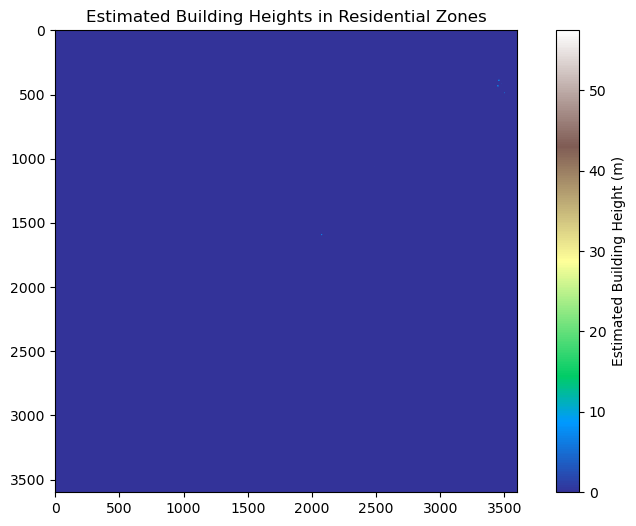

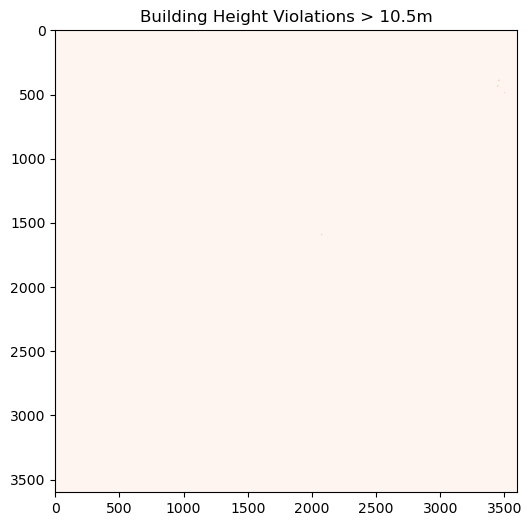

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(height_map, cmap='terrain')
plt.colorbar(label="Estimated Building Height (m)")
plt.title("Estimated Building Heights in Residential Zones")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(violations, cmap='Reds')
plt.title(f"Building Height Violations > {max_allowed_height}m")
plt.show()


In [25]:
# Step 1: Count violating pixels
violating_pixels = np.count_nonzero(violations)

# Step 2: Calculate area
pixel_area_m2 = 30 * 30  # for 30m resolution
total_violation_area_m2 = violating_pixels * pixel_area_m2

# Step 3: Convert to hectares or sq. km (optional)
total_violation_area_ha = total_violation_area_m2 / 10_000  # 1 ha = 10,000 m²
total_violation_area_km2 = total_violation_area_m2 / 1_000_000

# Step 4: Display
print(f"🚨 Total Violating Pixels: {violating_pixels}")
print(f"📏 Violation Area: {total_violation_area_m2:.2f} m²")
print(f"🌾 Violation Area: {total_violation_area_ha:.2f} hectares")
print(f"🗺️ Violation Area: {total_violation_area_km2:.4f} km²")


🚨 Total Violating Pixels: 90
📏 Violation Area: 81000.00 m²
🌾 Violation Area: 8.10 hectares
🗺️ Violation Area: 0.0810 km²


In [29]:
from shapely.geometry import Point
import geopandas as gpd
import rasterio

# Get row, col indices where violations occurred
rows, cols = np.where(violations)

# Convert to geographic coordinates
violation_points = []
for row, col in zip(rows, cols):
    lon, lat = rasterio.transform.xy(dsm_transform, row, col)
    violation_points.append(Point(lon, lat))

# Optional: convert to GeoDataFrame if needed
gdf = gpd.GeoDataFrame(geometry=violation_points, crs=dsm.crs)


In [41]:
import numpy as np
import rasterio

# 1. Sanity check: Print CRS and transform
print("DSM CRS:", dsm.crs)
print("DSM Transform:", dsm_transform)

# 2. Print bounds of DSM
print("DSM Bounds:", dsm.bounds)

# 3. Show sample coordinates
rows, cols = np.where(violations)
print("Sample pixel index:", rows[0], cols[0])

lon, lat = rasterio.transform.xy(dsm_transform, rows[0], cols[0])
print(f"Sample violation coordinate: lat={lat}, lon={lon}")


DSM CRS: EPSG:4326
DSM Transform: | 0.00, 0.00, 76.00|
| 0.00,-0.00, 31.00|
| 0.00, 0.00, 1.00|
DSM Bounds: BoundingBox(left=76.0000042809, bottom=30.0000076636, right=77.0000050809, top=31.0000084636)
Sample pixel index: 387 3459
Sample violation coordinate: lat=30.8923694886, lon=76.9609772719


In [ ]:
import folium
from shapely.geometry import Point

# Get coordinates and values for all violating pixels
rows, cols = np.where(violations)
violation_points = []
heights = []

for row, col in zip(rows, cols):
    lon, lat = rasterio.transform.xy(dsm_transform, row, col)
    violation_points.append((lat, lon))  # folium uses lat, lon
    heights.append(height_map[row, col])

# Create map
m = folium.Map(location=[30.74, 76.79], zoom_start=13)

# Add color-coded violation markers
for (lat, lon), h in zip(violation_points[:1000], heights[:1000]):  # Limit to 1000 markers for performance
    if h <= 10.5:
        continue  # skip non-violations
    elif h <= 15:
        color = 'orange'
    else:
        color = 'red'

    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=folium.Popup(f"Height: {h:.2f} m", parse_html=True)
    ).add_to(m)

legend_html = """
<div style="
     position: fixed;
     bottom: 50px;
     left: 50px;
     width: 180px;
     height: 120px;
     background-color: white;
     border:2px solid grey;
     z-index:9999;
     font-size:14px;
     padding: 10px;">
  <b>🏢 Height Violations</b><br>
  <i style='color:red;'>●</i> > 15m<br>
  <i style='color:orange;'>●</i> 10.5m – 15m<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

from folium.plugins import MeasureControl

m.add_child(MeasureControl(
    primary_length_unit='meters',
    secondary_length_unit='kilometers',
    primary_area_unit='sqmeters',
    secondary_area_unit='hectares'
))

m.save("violation_map_final.html")
import webbrowser, os
webbrowser.open(f"file://{os.path.abspath('violation_map_final.html')}")
print(f"Total violation markers to plot: {len(violation_points)}")
print("Sample:", violation_points[:3])



Total violation markers to plot: 90
Sample: [(76.9609772719, 30.8923694886), (76.9612550499, 30.8923694886), (76.9606994939, 30.8920917106)]


In [ ]:
import geopandas as gpd
import json

# Reproject zones to EPSG:4326 (WGS84 for folium)
zones = gpd.read_file(r"C:\Users\hp\Documents\MUDITA-doc\Projects\Illegal construction detection\HomogenousSubZones")


# Convert GeoDataFrame to GeoJSON
zones_json = json.loads(zones.to_json())

# Add boundary polygons to map
folium.GeoJson(
    zones_json,
    name="Sector Boundaries",
    style_function=lambda x: {
        'color': 'blue',
        'weight': 1,
        'fillOpacity': 0
    },
    tooltip=folium.GeoJsonTooltip(fields=[]),
).add_to(m)

# Add layer control (optional)
folium.LayerControl().add_to(m)


# Save map again with overlay
m.save("violation_map_with_boundaries.html")


C:\Users\hp\AppData\Local\Temp\ipykernel_9416\2619049528.py:9: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  zones_json = json.loads(zones.to_json())
